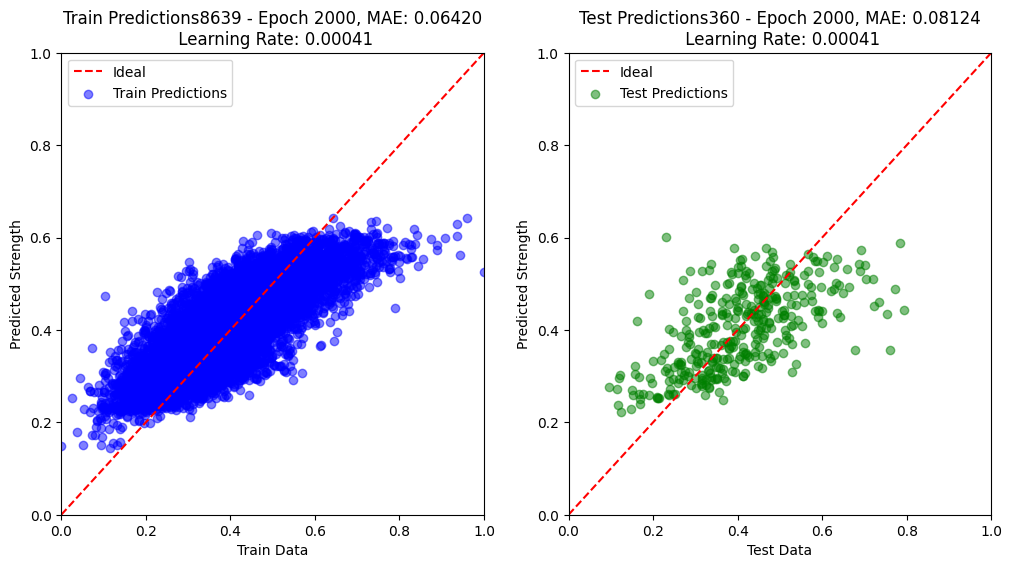

In [36]:
import numpy as np
import json
import os
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, GlobalAveragePooling2D, Dense, Dropout, Concatenate, Flatten, Reshape,Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from CallBacks import PrintLossCallback, EarlyStoppingByTrainMAE, LiveScatterTwoOutputs
from tensorflow.keras.initializers import HeNormal, GlorotUniform

Iteration=2000
lr=0.0005
train_size = 0.96
limit=0.04
l2value=0.0001
reduceRate=0.9
modelPath="ANN-4-5.keras"
drop=0.2
batch=100
act="swish"
init=GlorotUniform()
# Load node data (25 nodes, 3 features: x, y, z)
with open("nodexy.txt", "r") as file:
    NodeOriginal = json.load(file)
NodeOriginal = np.array(NodeOriginal)  # Convert to NumPy array
# Load element data (features for each sample)
with open("thickness.txt", "r") as file:
    element_features = json.load(file)
element_features = np.array(element_features)  # Convert to NumPy array
# Load target values
energy = np.loadtxt("energy_absorbed.txt")
energy = np.array(energy).reshape(-1, 1)  # Ensure correct shape
minValue=np.argmin(energy)
mask1=np.arange((len(energy))) !=minValue
NodeOriginal=NodeOriginal[mask1,:,:]
element_features=element_features[mask1,:]
energy=energy[mask1]
# Extract x, y coordinates
NodeOriginal_x = NodeOriginal[:, :, 0]  # Extract all x-coordinates
NodeOriginal_y = NodeOriginal[:, :, 1]  # Extract all y-coordinates
# Identify and remove edge nodes (x or y = 0 or 30)
_, EdgeNodes = np.where((NodeOriginal_x == 0) | (NodeOriginal_x == 30) | (NodeOriginal_y == 0) | (NodeOriginal_y == 30))
EdgeNodes = np.unique(EdgeNodes)  # Get unique node indices to remove
# Create a mask and filter out edge nodes
mask2 = np.ones(NodeOriginal.shape[1], dtype=bool)
mask2[EdgeNodes] = False
filtered_nodes = NodeOriginal[:, mask2, :]
print(filtered_nodes.shape)

# Normalize data
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
scaler_z = MinMaxScaler()
element_scaler = MinMaxScaler()
energy_scaler = MinMaxScaler()

nodex = scaler_x.fit_transform(filtered_nodes[ :, :, 0])
nodey = scaler_y.fit_transform(filtered_nodes[ :, :, 1])
NodeFeature=np.stack([nodex,nodey],axis=-1)
print(NodeFeature.shape)
element_features = element_scaler.fit_transform(element_features)
energy = energy_scaler.fit_transform(energy)

# Split data into training and testing sets
X_train_nodes, X_test_nodes, X_train_elements, X_test_elements, y_train, y_test = train_test_split(
    NodeFeature, element_features, energy, test_size=1 - train_size, random_state=42)
print(NodeFeature.shape[1],NodeFeature.shape[2])
# Define CNN model for node features
node_input = Input((NodeFeature.shape[1],NodeFeature.shape[2]), name="Node_Input")
node_branch=Dense(75,activation=act,kernel_regularizer=l2(l2value),kernel_initializer=init)(node_input)
node_branch=Dense(50,activation=act,kernel_regularizer=l2(l2value),kernel_initializer=init)(node_branch)
node_branch=Dense(40,activation=act,kernel_initializer=init)(node_branch)
node_branch=Dropout(drop)(node_branch)
node_branch=Dense(30,activation=act,kernel_initializer=init)(node_branch)
node_branch=Dropout(drop)(node_branch)
node_branch=Flatten()(node_branch)
# Define ANN model for element features
element_input  = Input((X_train_elements.shape[1],), name="Element_Input")
element_branch = Dense(75, activation=act,kernel_regularizer=l2(l2value),kernel_initializer=init)(element_input)
element_branch = Dense(50, activation=act,kernel_regularizer=l2(l2value),kernel_initializer=init)(element_branch)
element_branch = Dense(40, activation=act,kernel_initializer=init)(element_branch)
element_branch = Dropout(drop)(element_branch)
element_branch = Dense(30, activation=act,kernel_initializer=init)(element_branch)
element_branch = Dropout(drop)(element_branch)

# Concatenate CNN and ANN features
merged = Concatenate()([node_branch, element_branch])
latentSpace=Dense(60,activation=act,kernel_regularizer=l2(l2value),kernel_initializer=init)(merged)
latentSpace=Dense(35,activation=act,kernel_initializer=init)(latentSpace)
latentSpace=Dropout(drop)(latentSpace)
latentSpace=Dense(15,activation=act,name="Latent",kernel_initializer=init)(latentSpace)
latentSpace=Dropout(drop)(latentSpace)
merged = Dense(4, activation=act,kernel_initializer=init)(latentSpace)
merged = Dense(2, activation=act,kernel_initializer=init)(merged)
encode = Dense(1, activation=act, name="Encode",kernel_initializer=init)(merged)

decoded = Dense(30, activation=act,kernel_regularizer=l2(l2value),kernel_initializer=init)(latentSpace)
decoded = Dense(60, activation=act,kernel_regularizer=l2(l2value),kernel_initializer=init)(decoded)
decoded = Dense((NodeFeature.shape[1]*NodeFeature.shape[2]), activation=act,kernel_regularizer=l2(l2value),kernel_initializer=init)(decoded)
decode = Reshape((NodeFeature.shape[1],NodeFeature.shape[2]),name="Decode")(decoded)


# Create model
if os.path.exists(modelPath):
    print("Loading model")
    model=load_model(modelPath)
else:
    print("Creating model")
    model = Model(inputs=[node_input, element_input], outputs=[encode,decode])
model.compile(optimizer=Adam(learning_rate=lr), 
              loss={"Encode": "huber", "Decode": "huber"},
              metrics={"Encode": ["mae", "mse"], "Decode": ["mae", "mse"]})

# Define callbacks for early stopping and learning rate reduction
checkpoint = ModelCheckpoint(modelPath, monitor="val_Encode_mae", save_best_only=True, mode="min", verbose=0)
reduce_lr = ReduceLROnPlateau(monitor="Encode_mae", factor=reduceRate, patience=200, min_lr=1e-6, verbose=0)
X_train_nodes = np.array(X_train_nodes, dtype=np.float32)
LossMonitor = PrintLossCallback("Encode_mae",interval=500)
early_stopping = EarlyStoppingByTrainMAE("Encode_mae",threshold=limit)
plot=LiveScatterTwoOutputs(X_train_nodes,X_test_nodes, X_train_elements,X_test_elements, y_train, y_test, interval=10)

print(f"Model output shapes: {[o.shape for o in model.outputs]}")
print(f"y_train shape: {y_train.shape}") 
print(f"X_train_nodes shape: {X_train_nodes.shape}")

# Train model
history = model.fit(
    [X_train_nodes, X_train_elements],
    [y_train, X_train_nodes],
    epochs=Iteration,
    batch_size=batch,
    validation_split=0.05,
    callbacks=[checkpoint,LossMonitor,reduce_lr,plot],
    verbose=0
)
